#Mood Detection using EEG Data


In [1]:
# ========================
# 📦 Import Dependencies
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ========================
# 📥 Load Dataset
# ========================
data = pd.read_csv("emotions.csv")
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (2132, 2549)
   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744

In [36]:
from joblib import dump
# ========================
# 🎯 Encode Labels & Scale
# ========================
def transform_data(data):
    # Encode labels to numbers
    encoding_map = {'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2}
    data_encoded = data.replace(encoding_map)

    # Separate features & labels
    X = data_encoded.drop(["label"], axis=1).values
    y = data_encoded["label"].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # One-hot encode labels
    y_onehot = to_categorical(y, num_classes=3)

    return X_scaled, y_onehot, scaler

X, Y, scaler = transform_data(data)

# After creating and fitting the scaler in transform_data()
X, Y, scaler = transform_data(data)

# Save scaler to disk
dump(scaler, 'scaler.save')

# Shuffle and split dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42, shuffle=True
)
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")


/tmp/ipython-input-2517790881.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(encoding_map)
/tmp/ipython-input-2517790881.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(encoding_map)


Train shape: (1918, 2548), Test shape: (214, 2548)


Test set label counts:
NEUTRAL: 635
POSITIVE: 647
NEGATIVE: 636


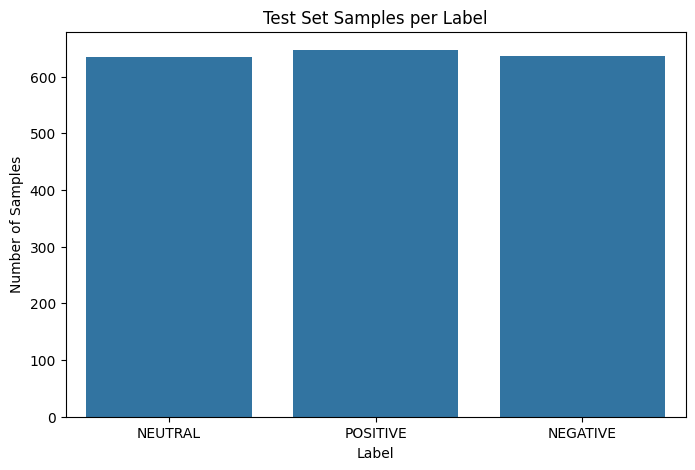

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Map from index back to label names
label_map = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}

# Convert one-hot back to label indices for test set
test_labels_idx = np.argmax(y_train, axis=1)

# Count samples per label
(unique, counts) = np.unique(test_labels_idx, return_counts=True)
label_counts = dict(zip(unique, counts))

# Print counts
print("Test set label counts:")
for idx, count in label_counts.items():
    print(f"{label_map[idx]}: {count}")

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=[label_map[i] for i in unique], y=counts)
plt.title("Test Set Samples per Label")
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.show()

In [44]:
x_train.shape[1]

2548

In [49]:
import tensorflow as tf

def create_enhanced_dense_model():
    inputs = tf.keras.Input(shape=(2548,))

    # Dense layers with BatchNorm and Dropout
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Output layer
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create & compile
model = create_enhanced_dense_model()
model.summary()


Model: "functional_936"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_937 (InputLayer)    │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5616 (Dense)              │ (None, 512)            │     1,305,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3743        │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3743 (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5617 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3744        │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3744 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5618 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3745        │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3745 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5619 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3746        │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3746 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5620 (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5621 (Dense)              │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,485,763 (5.67 MB)

 Trainable params: 1,483,843 (5.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [50]:
# ========================
# 📈 Train Model
# ========================
history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.5482 - loss: 1.0901 - val_accuracy: 0.7188 - val_loss: 1.1071
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8245 - loss: 0.4857 - val_accuracy: 0.8594 - val_loss: 0.3357
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8513 - loss: 0.3934 - val_accuracy: 0.9219 - val_loss: 0.1676
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8775 - loss: 0.3042 - val_accuracy: 0.9271 - val_loss: 0.1626
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9080 - loss: 0.2409 - val_accuracy: 0.9375 - val_loss: 0.1576
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9084 - loss: 0.2624 - val_accuracy: 0.9323 - val_loss: 0.1634
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9029 - loss: 0.2461 - val_accuracy: 0.9323 - val_loss: 0.1516
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9203 - loss: 0.2268 - val_accuracy: 0.9271 -

In [ ]:
# ========================
# 💾 Save Model Weights
# ========================
model.save_weights("eeg_model_.weights.h5")
print("✅ Model weights saved to eeg_model_weights.h5")

In [52]:

# ========================
# 📊 Evaluate Model
# ========================
model.load_weights("eeg_model_.weights.h5")
loss, acc = model.evaluate(x_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# ========================
# 🔍 Inference Function
# ========================
label_map = {0: "NEUTRAL", 1: "POSITIVE", 2: "NEGATIVE"}

def predict_emotion(eeg_sample, scaled=False):
    if not scaled:
        eeg_sample = scaler.transform([eeg_sample])
    else:
        eeg_sample = np.expand_dims(eeg_sample, axis=0)  # add batch dim

    pred = model.predict(eeg_sample)
    label_idx = np.argmax(pred)
    confidence = pred[0][label_idx]
    return label_map[label_idx], confidence


# Example: Predict from test set
sample_idx = 120


# Predict
pred_label, conf = predict_emotion(x_test[sample_idx], scaled=True)


# Get actual label index from one-hot vector
actual_label_idx = np.argmax(y_test[sample_idx])

# Map to label string
actual_label = label_map[actual_label_idx]

print(f"Actual: {actual_label}")
print(f"Predicted: {pred_label} ({conf*100:.2f}% confidence)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9953 - loss: 0.0204
✅ Test Accuracy: 99.07%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Actual: POSITIVE
Predicted: POSITIVE (100.00% confidence)


#Inference Module for Mood Detection using EEG data

In [55]:
import pandas as pd
from joblib import load
import tensorflow as tf

def create_enhanced_dense_model():
    inputs = tf.keras.Input(shape=(2548,))

    # Dense layers with BatchNorm and Dropout
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Output layer
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load saved scaler
def Final_Prediction():
  scaler = load('scaler.save')

  # Load your new CSV
  new_data = pd.read_csv('/content/file.csv')

  # Drop label column if exists
  if 'label' in new_data.columns:
      new_data = new_data.drop(columns=['label'])

  X_new = new_data.values

  # Scale features
  X_new_scaled = scaler.transform(X_new)

  # Predict using model
  model = create_enhanced_dense_model()
  model.load_weights("eeg_model_.weights.h5")
  predictions = model.predict(X_new_scaled)

  # Decode predictions
  predicted_classes = predictions.argmax(axis=1)
  label_map = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}
  predicted_labels = [label_map[c] for c in predicted_classes]
  return predicted_labels

predicted_labels = Final_Prediction()

print(predicted_labels)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
['NEUTRAL']


#Mood detection using face image


In [3]:
from google.colab import files
import os
import pandas as pd

# Step 1: Upload Kaggle API token
files.upload()  # Upload the kaggle.json file

# Step 2: Set up Kaggle API credentials
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Step 3: Install Kaggle API
!pip install kaggle

# Step 4: Download the dataset
dataset_identifier = 'jonathanoheix/face-expression-recognition-dataset'
download_path = '/content/dataset'
os.makedirs(download_path, exist_ok=True)
!kaggle datasets download -d {dataset_identifier} -p {download_path} --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
100% 120M/121M [00:00<00:00, 1.25GB/s]
100% 121M/121M [00:00<00:00, 1.25GB/s]


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Dropout, Flatten, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

# Paths - Adjust if necessary
data_dir = '/content/dataset/images/images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

# --- Define Residual Block ---
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second conv layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection with possible downsampling
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# --- Build Model ---
def build_resnet_like_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, 3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks with increasing filters
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=2)  # Downsample
    x = residual_block(x, 128)

    x = residual_block(x, 128, strides=2)  # Downsample
    x = residual_block(x, 128)

    x = residual_block(x, 128, strides=2)  # Downsample
    x = residual_block(x, 128)

    # Global Max Pooling + Dense layers
    x = MaxPooling2D(pool_size=4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    return model

model = build_resnet_like_model()
model.load_weights('/content/resnet_.weights.h5')
model.summary()

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1
)

# --- Train Model ---
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_reduction]
)

# --- Evaluation ---
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# --- Plot training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

# --- Confusion Matrix on Validation Set ---
# Get true labels and predictions
val_steps = validation_generator.samples // validation_generator.batch_size + 1
y_true = []
y_pred = []

for _ in range(val_steps):
    X_val, y_val = next(validation_generator)
    preds = model.predict(X_val)
    y_true.extend(np.argmax(y_val, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
print(classification_report(y_true, y_pred, target_names=class_names))


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 48, 48,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 48, 48,    │     36,928 │ activation_17[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 48, 48,    │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 48, 48,    │          0 │ add_8[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 48, 48,    │     36,928 │ activation_19[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 48, 48,    │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 48, 48,    │          0 │ batch_normalizat

 Total params: 1,967,623 (7.51 MB)

 Trainable params: 1,962,119 (7.48 MB)

 Non-trainable params: 5,504 (21.50 KB)

Epoch 1/5
 61/451 ━━━━━━━━━━━━━━━━━━━━ 36:22 6s/step - accuracy: 0.6595 - loss: 0.8921

KeyboardInterrupt: 

In [61]:
model.save_weights('resnet_.weights.h5')

#Inference Module for Mood Detection using Face Images

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Dropout, Flatten, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
# --- Define Residual Block ---
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second conv layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection with possible downsampling
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
def build_resnet_like_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, 3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks with increasing filters
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=2)  # Downsample
    x = residual_block(x, 128)

    x = residual_block(x, 128, strides=2)  # Downsample
    x = residual_block(x, 128)

    x = residual_block(x, 128, strides=2)  # Downsample
    x = residual_block(x, 128)

    # Global Max Pooling + Dense layers
    x = MaxPooling2D(pool_size=4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    return model

def preprocess_image(img_path, target_size=(48,48)):
    # Load image in grayscale mode
    img = image.load_img(img_path, color_mode='grayscale', target_size=target_size)
    # Convert to numpy array
    img_array = image.img_to_array(img)
    # Normalize pixel values to [0,1]
    img_array = img_array / 255.0
    # Add batch dimension: (48,48,1) -> (1,48,48,1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_single_image( img_path, class_names):
    # Preprocess image
    img = preprocess_image(img_path)

    # Predict probabilities
    model = build_resnet_like_model()
    model.load_weights('/content/resnet_.weights.h5')
    preds = model.predict(img)
    print(preds)
    pred_class_idx = np.argmax(preds)
    confidence = preds[0][pred_class_idx]

    predicted_label = class_names[pred_class_idx]
    return predicted_label


# 2. Define your class names (must match training classes order)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 # replace with your classes

# 3. Predict on a new image
img_path = '/content/The_joy_of_the_happy_face_by_Rasheedhrasheed.jpg'
label = predict_single_image(img_path, class_names)

print(f"Predicted Label: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[4.5457343e-04 5.6263872e-07 1.2919845e-04 9.9761260e-01 1.3169019e-03
  3.4277272e-04 1.4354814e-04]]
Predicted Label: happy


In [2]:
import tensorflow as tf
print(tf.__version__)
import sys
print(sys.version)



2.19.0
3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [8]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
